# [Insert Creative Title HERE]

## Introduction and Motivation

This project attempts to use data science in order to 

## Required Libraries

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#


In [23]:
import sys
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, metrics
import plotly.graph_objects as go
import seaborn as sns

## Data Collection and Tidying
//TODO Talk about general authentication flow.<br>
//TODO Link example resource. <br>
//TODO Explain how to get the spotify username<br>
//TODO talk about how we chose what columns to keep. Talk about how data is relatively simple and no need to reorganize

In [2]:
# Generate authorization token for reading user library
username = '12124976904'

scope = 'user-library-read playlist-modify-public'
client_id = '076ff5215a374d2481d0117877d79b74'
client_secret = '0ff2fd29106e4b7ebd7da4152d4a20c3'
redirect_uri = 'https://www.google.com/'

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

else:
    print("Can't get token for", username)
    sys.exit()

//TODO explain the code flow <br>
//TODO talk about how we chose what columns to keep. <br>
//TODO Talk about how data is relatively simple and no need to reorganize <br>

In [3]:
def get_saved_tracks():
    results = sp.current_user_saved_tracks()
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

print('Loading Saved Tracks Now. Please be patient!')

if True:
    tracks = get_saved_tracks()
    features = []
    track_info = []
    artist_uris = {}
    
    for track in tracks:
        track = track['track']
        features.extend(sp.audio_features(track['uri']))
        track_info.append([track['name'], track['artists'][0]['name']])
        artist_uris[track['artists'][0]['name']] = track['artists'][0]['uri']

    features = pd.DataFrame(features)
    track_info = pd.DataFrame(track_info).rename(columns={0: "title", 1: "artist"})

    features = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
    features['tempo'] = (features['tempo']-features['tempo'].min())/(features['tempo'].max()-features['tempo'].min())

else:
    features = pd.read_csv('sample_data') #TODO download the dataframe as a csv and add to path
    
features

Loading Saved Tracks Now. Please be patient!
retrying ...1secs
retrying ...1secs


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.356000,0.586,0.918,0.001530,0.379245,0.310
1,0.880000,0.324,0.428,0.000013,0.784055,0.243
2,0.017500,0.810,0.731,0.000141,0.589816,0.622
3,0.011600,0.562,0.850,0.000000,0.470217,0.410
4,0.162000,0.725,0.680,0.000002,0.431567,0.760
...,...,...,...,...,...,...
423,0.000056,0.579,0.865,0.000221,0.333120,0.358
424,0.469000,0.576,0.451,0.038900,0.237295,0.803
425,0.360000,0.671,0.740,0.000000,0.214200,0.908
426,0.150000,0.424,0.875,0.000000,0.748454,0.440


## Exploratory Data Analysis & Visualizations

In [4]:
#Explain the columns and how values are determined.
# Summary Statistics
# Histograms
# Correlation Graphs

In [54]:
features.describe()

,acousticness,danceability,energy,instrumentalness,tempo,valence,Cluster
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.267391,0.651002,0.598219,0.027620,0.443832,0.450615,3.011682
std,0.287885,0.154714,0.186267,0.122673,0.194017,0.228727,1.599869
min,0.000041,0.240000,0.068200,0.000000,0.000000,0.037900,0.000000
25%,0.030550,0.549500,0.479000,0.000000,0.288062,0.269250,2.000000
50%,0.153000,0.670000,0.607500,0.000002,0.437718,0.415500,3.000000
75%,0.407750,0.763000,0.741250,0.000479,0.592813,0.627250,4.000000
max,0.979000,0.961000,0.988000,0.878000,1.000000,0.968000,5.000000


In [50]:
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm')

,acousticness,danceability,energy,instrumentalness,tempo,valence,Cluster
acousticness,1,-0.377397,-0.588312,0.216891,-0.123963,-0.110016,-0.492914
danceability,-0.377397,1,0.132252,-0.009904,0.0516756,0.149749,0.0265108
energy,-0.588312,0.132252,1,-0.10783,0.0171763,0.397619,0.21441
instrumentalness,0.216891,-0.009904,-0.10783,1,0.0393062,-0.142701,-0.203425
tempo,-0.123963,0.0516756,0.0171763,0.0393062,1,-0.104967,-0.0579379
valence,-0.110016,0.149749,0.397619,-0.142701,-0.104967,1,-0.168019
Cluster,-0.492914,0.0265108,0.21441,-0.203425,-0.0579379,-0.168019,1


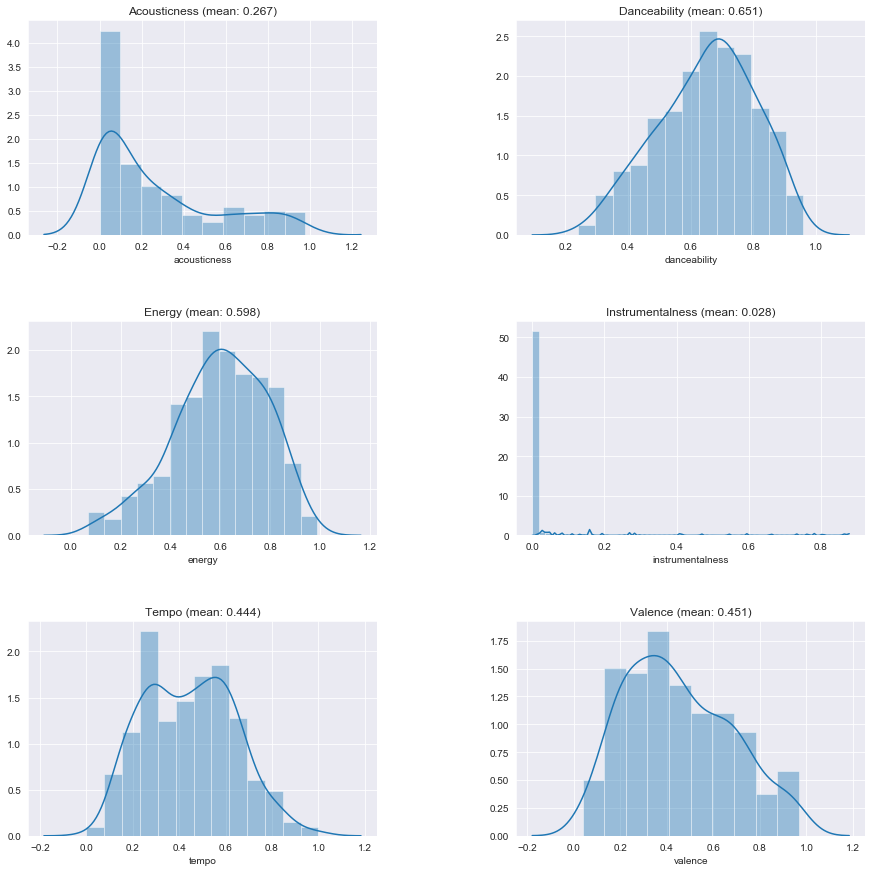

In [43]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.set_figheight(15)
fig.set_figwidth(15)

ax = fig.add_subplot(3, 2, 1)
ax.set_title("Acousticness" + " (mean: " + str(np.round(features['acousticness'].mean(), 3)) + ")")
sns.distplot(features['acousticness'],ax=ax)

ax = fig.add_subplot(3, 2, 2)
ax.set_title("Danceability" + " (mean: " + str(np.round(features['danceability'].mean(), 3)) + ")")
sns.distplot(features['danceability'])

ax = fig.add_subplot(3, 2, 3)
ax.set_title("Energy" + " (mean: " + str(np.round(features['energy'].mean(), 3)) + ")")
sns.distplot(features['energy'])

ax = fig.add_subplot(3, 2, 4)
ax.set_title("Instrumentalness" + " (mean: " + str(np.round(features['instrumentalness'].mean(), 3)) + ")")
sns.distplot(features['instrumentalness'])

ax = fig.add_subplot(3, 2, 5)
ax.set_title("Tempo" + " (mean: " + str(np.round(features['tempo'].mean(), 3)) + ")")
sns.distplot(features['tempo'])

ax = fig.add_subplot(3, 2, 6)
ax.set_title("Valence" + " (mean: " + str(np.round(features['valence'].mean(), 3)) + ")")
sns.distplot(features['valence'])
plt.show()

## Machine Learning

In [7]:
# Found cool article on PCA & One Class SVM here:
# https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3
# Implementation is found here:
# http://www.esparsons.com/blogmain/2018/11/27/an-eclectic-spotify-library-visualized-with-chartify

#TODO One Class SVM
#TODO Clustering: Model selection (affinity propagation, mean shift, agglomerative clustering - davies-bouldin index)
#TODO get top songs from similar artists, match them to clusters, find closest matching songs with silhouette score,
#create playlists
#TODO EDA for the individual playlists (highlighting common features between library songs and recommended songs)

#TODO Error analysis...
#TODO Check if new playlists can fit into the SVM

### Clustering & Principal Component Analysis

In [8]:
affinity = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0
temp = features
while (len(affinity.cluster_centers_) > 6):
    pref -= 1
    affinity = cluster.AffinityPropagation(preference=pref).fit(features.values)
clusters = affinity
features['Cluster'] = clusters.labels_
track_info['Cluster'] = clusters.labels_
track_info.iloc[clusters.cluster_centers_indices_]

,title,artist,Cluster
68,Possible,Sincerely Collins,0
170,"Welcome Home, Son",Radical Face,1
250,Ivy,Frank Ocean,2
255,Sanguine Paradise,Lil Uzi Vert,3
270,Graduation (with Juice WRLD),benny blanco,4
316,Breakeven,The Script,5


In [9]:
#Can play with this to see the songs in each cluster
track_info.loc[track_info['Cluster'] == 0]

,title,artist,Cluster
4,Am I Wrong,Nico & Vinz,0
25,Yesterday,Atmosphere,0
31,The Nosebleed Section,Hilltop Hoods,0
45,Please Mr. Postman - Single Version / Mono,The Marvelettes,0
57,Love Me Now,John Legend,0
63,I Feel It Coming,The Weeknd,0
64,Caroline,Aminé,0
68,Possible,Sincerely Collins,0
80,Forever,P-Square,0
85,Closer,The Chainsmokers,0


In [10]:
pca = decomposition.PCA(n_components=2)
features_2d = pd.DataFrame(pca.fit_transform(features.loc[:,:'valence']), columns=['Component 1', 'Component 2'])
features_2d['Cluster'] = clusters.labels_
print(pca.explained_variance_ratio_)
features_2d.head(10)

[0.43554842 0.22340241]


,Component 1,Component 2,Cluster
0,-0.013228,-0.006005,5
1,0.676086,-0.115102,2
2,-0.355428,0.031180,4
3,-0.296899,-0.079487,5
4,-0.221111,0.246697,0
5,-0.249048,-0.279736,3
6,-0.176132,-0.052761,4
7,0.748881,0.282385,2
8,-0.079194,0.153039,4
9,-0.194912,-0.133856,3


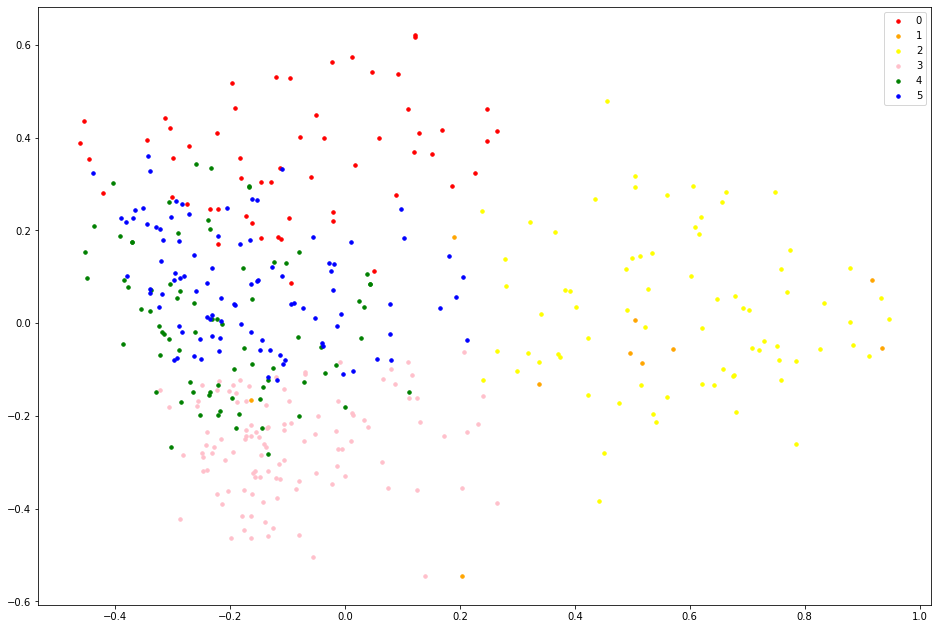

In [11]:
colors = ['red', 'orange', 'yellow', 'pink', 'green', 'blue', 'purple', 'black', 'cyan', 'grey']
fig, ax = plt.subplots(figsize=(16,11))
features_2d = features_2d.sort_values('Cluster')

for cluster_label in features_2d['Cluster'].unique():
    group = features_2d.loc[features_2d['Cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=12)
    
ax.legend()

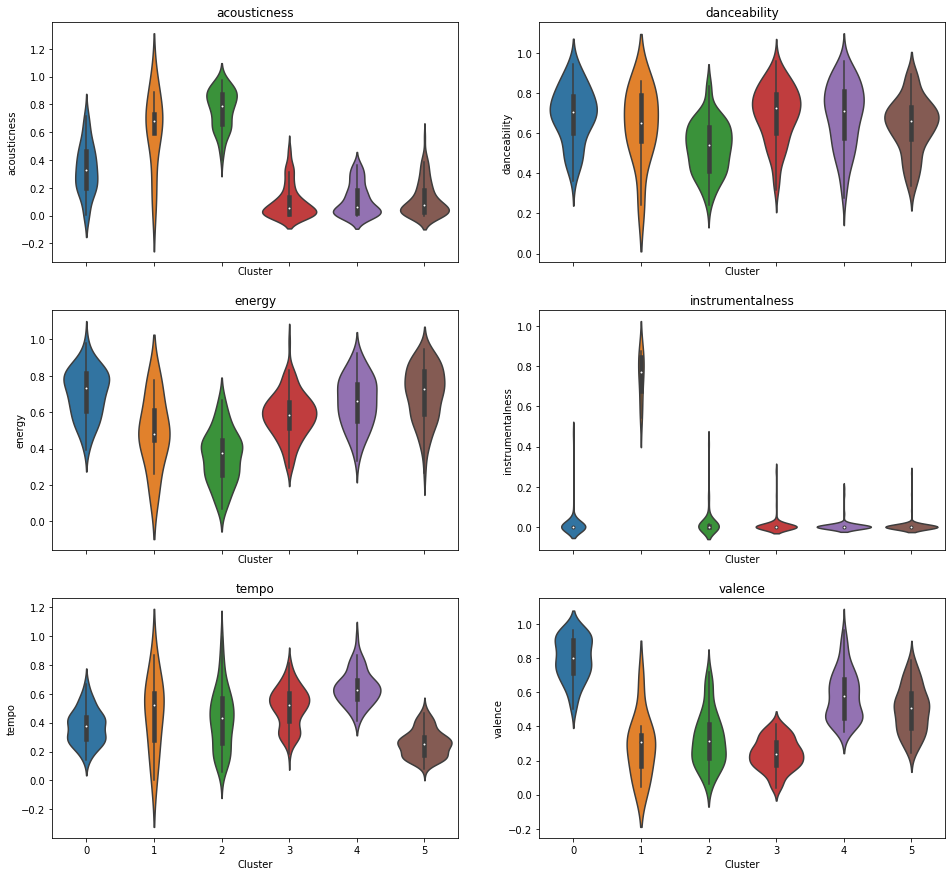

In [12]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for col in features.loc[:,:'valence'].columns:
    seaborn.violinplot(features['Cluster'], features[col], ax=ax[idx])
    ax[idx].set_title(col)
    idx += 1

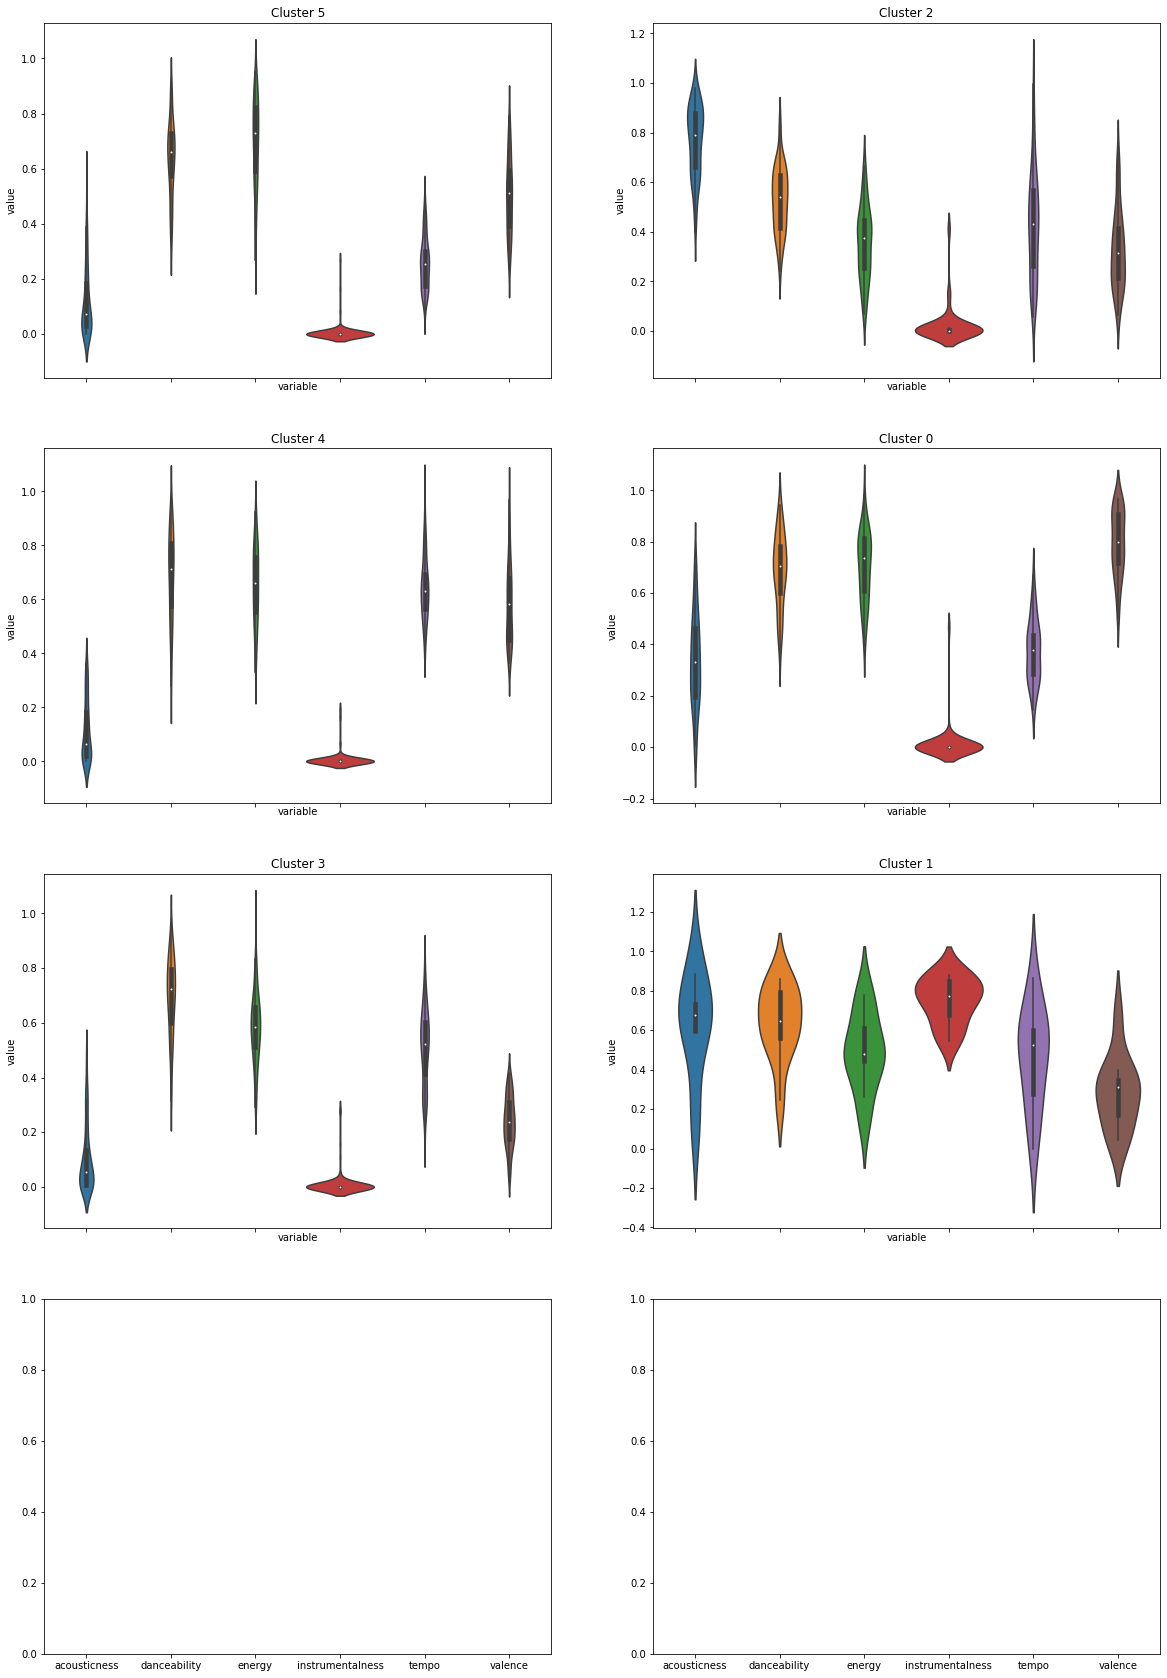

In [13]:
fig, ax = plt.subplots(int((len(clusters.cluster_centers_))/2) + 1, 2, sharex=True, figsize=(20, 30))
ax = ax.flatten()
idx = 0

for cluster_label in features['Cluster'].unique():
    group = features.loc[features['Cluster'] == cluster_label].drop('Cluster', axis=1).melt()
    seaborn.violinplot(x=group['variable'], y=group['value'], data=group, ax=ax[idx])
    ax[idx].set_title("Cluster " + str(cluster_label))
    idx += 1

### Finding Similar Songs

In [14]:
artists = track_info.groupby('artist').count().drop('Cluster', axis=1).reset_index().rename(columns={"title": "count"})
artists = artists.sort_values('count', ascending=False).head(25)
artists['uri'] = [artist_uris[artist] for artist in artists['artist']]
artists.head(5)

,artist,count,uri
51,Drake,21,spotify:artist:3TVXtAsR1Inumwj472S9r4
197,The Weeknd,20,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ
22,Bon Iver,18,spotify:artist:4LEiUm1SRbFMgfqnQTwUbQ
78,Hozier,10,spotify:artist:2FXC3k01G6Gw61bmprjgqS
69,Future,10,spotify:artist:1RyvyyTE3xzB2ZywiAwp0i


In [15]:
related_tracks = []
known_artists = set(track_info['artist'])

for tup in artists.itertuples():
    for artist in sp.artist_related_artists(tup.uri)['artists'][:12]:
        
        if artist['name'] not in known_artists:
            known_artists.add(artist['name'])
            
            for track in sp.artist_top_tracks(artist['uri'])['tracks'][:5]:
                related_tracks.append([track['name'], track['artists'][0]['name'], track['uri']])
    
related_tracks = pd.DataFrame(related_tracks).rename(columns={0: "title", 1: "artist", 2: "uri"})
related_tracks

,title,artist,uri
0,Bezerk (feat. A$AP Ferg & Hit-Boy),Big Sean,spotify:track:2B9wgj9XzbJZLty03PRbVo
1,Bounce Back,Big Sean,spotify:track:0SGkqnVQo9KPytSri1H6cF
2,I Don't Fuck With You,Big Sean,spotify:track:7FYH5AW3bVfZHJIQpq3UOA
3,Single Again,Big Sean,spotify:track:7IP0lO9tHfNwBWZ9X6TJ84
4,Jump Out The Window,Big Sean,spotify:track:1jQsKN68yE94tMYml0wHMd
...,...,...,...
900,Hot Girl Summer (feat. Nicki Minaj & Ty Dolla ...,Megan Thee Stallion,spotify:track:5N1o6d8zGcSZSeMFkOUQOk
901,Nights Like This (feat. Ty Dolla $ign),Kehlani,spotify:track:6ZRuF2n1CQxyxxAAWsKJOy
902,OTW,Khalid,spotify:track:6Hgh47WXVKtXN5zGOu0hjI
903,"Or Nah (feat. The Weeknd, Wiz Khalifa & DJ Mus...",Ty Dolla $ign,spotify:track:7t2bFihaDvhIrd2gn2CWJO


In [16]:
rec_features = []

for uri in related_tracks['uri']:
    rec_features.extend(sp.audio_features(uri))

rec_features = pd.DataFrame(rec_features)
rec_features = rec_features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
rec_features['tempo'] = (rec_features['tempo']-rec_features['tempo'].min())/ \
                        (rec_features['tempo'].max()-rec_features['tempo'].min())
rec_features

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.01640,0.684,0.687,0.000000,0.821576,0.265
1,0.10400,0.780,0.574,0.000000,0.139801,0.273
2,0.03550,0.824,0.733,0.000000,0.249318,0.393
3,0.16100,0.635,0.677,0.000000,0.229229,0.253
4,0.13600,0.747,0.704,0.000000,0.508432,0.494
...,...,...,...,...,...,...
900,0.00485,0.872,0.814,0.000002,0.256061,0.570
901,0.36700,0.610,0.725,0.000000,0.569791,0.291
902,0.18300,0.652,0.678,0.000033,0.083190,0.280
903,0.22000,0.805,0.330,0.000000,0.408910,0.211


In [17]:
rec_features['cluster'] = clusters.predict(rec_features)
rec_features['silhouette'] = metrics.silhouette_samples(rec_features.loc[:'valence'], rec_features['cluster'])
rec_features[['title', 'artist', 'uri']] = related_tracks[['title', 'artist', 'uri']]
rec_features.head(10)

,acousticness,danceability,energy,instrumentalness,tempo,valence,cluster,silhouette,title,artist,uri
0,0.0164,0.684,0.687,0.000000,0.821576,0.2650,3,0.579032,Bezerk (feat. A$AP Ferg & Hit-Boy),Big Sean,spotify:track:2B9wgj9XzbJZLty03PRbVo
1,0.1040,0.780,0.574,0.000000,0.139801,0.2730,5,0.682463,Bounce Back,Big Sean,spotify:track:0SGkqnVQo9KPytSri1H6cF
2,0.0355,0.824,0.733,0.000000,0.249318,0.3930,5,0.695713,I Don't Fuck With You,Big Sean,spotify:track:7FYH5AW3bVfZHJIQpq3UOA
3,0.1610,0.635,0.677,0.000000,0.229229,0.2530,5,0.694527,Single Again,Big Sean,spotify:track:7IP0lO9tHfNwBWZ9X6TJ84
4,0.1360,0.747,0.704,0.000000,0.508432,0.4940,4,0.674394,Jump Out The Window,Big Sean,spotify:track:1jQsKN68yE94tMYml0wHMd
5,0.2130,0.418,0.724,0.000000,0.119978,0.6040,5,0.639623,oui,Jeremih,spotify:track:0PJIbOdMs3bd5AT8liULMQ
6,0.1060,0.697,0.400,0.000000,0.788200,0.4430,4,0.564113,Impatient,Jeremih,spotify:track:3WjyiSbfR74pjWXQ3IaFKJ
7,0.3920,0.856,0.527,0.000000,0.249857,0.3860,5,0.625148,Don't Tell 'Em,Jeremih,spotify:track:0Dc7J9VPV4eOInoxUiZrsL
8,0.7000,0.688,0.556,0.000002,0.457893,0.4160,2,0.646107,Planez,Jeremih,spotify:track:08zJpaUQVi9FrKv2e32Bah
9,0.5450,0.675,0.440,0.000006,0.328133,0.0338,2,0.556270,All The Time,Jeremih,spotify:track:0USZx50eApN045zIIyjePN


In [18]:
grouped = rec_features.groupby('cluster').apply(lambda x: x.sort_values('silhouette', ascending=False).head(12))
grouped = grouped.reset_index(drop=True)
grouped

,acousticness,danceability,energy,instrumentalness,tempo,valence,cluster,silhouette,title,artist,uri
0,0.2100,0.761,0.670,0.000426,0.400810,0.910,0,0.788310,Raspberry Beret,Prince,spotify:track:5jSz894ljfWE0IcHBSM39i
1,0.2330,0.703,0.706,0.001090,0.469404,0.766,0,0.784037,I Drove All Night,Cyndi Lauper,spotify:track:3J0AoQhAufniMrznCRJASD
2,0.2900,0.762,0.670,0.000006,0.259307,0.870,0,0.780496,It's My House,Diana Ross,spotify:track:7yAslROTLRHGwuiLBpdErT
3,0.2490,0.687,0.630,0.000000,0.329649,0.926,0,0.780288,Think,Aretha Franklin,spotify:track:4yQw7FR9lcvL6RHtegbJBh
4,0.1750,0.771,0.659,0.035600,0.333952,0.742,0,0.779337,"Can't Get Enough Of Your Love, Babe",Barry White,spotify:track:7LaCgCP7FCol0RYwMDQKwK
...,...,...,...,...,...,...,...,...,...,...,...
67,0.1370,0.760,0.746,0.000000,0.262884,0.449,5,0.726373,Jerry Sprunger (with T-Pain),Tory Lanez,spotify:track:6JsHgIkMYHcbNtKfsal2Mg
68,0.0481,0.672,0.569,0.000000,0.236019,0.460,5,0.726188,Church,BJ The Chicago Kid,spotify:track:6PmnGYDsruYLBNY4Rpx4t9
69,0.0724,0.629,0.608,0.000000,0.282900,0.413,5,0.725980,Infatuation,Takeoff,spotify:track:00I0pcNkN3IOX3fsYbaB4N
70,0.0337,0.736,0.719,0.000000,0.209465,0.504,5,0.725515,Stroke Me,Mickey Avalon,spotify:track:04vGO36ZMrGzqNjTVdopHL


In [20]:
for cluster_label in grouped['cluster'].unique():
    cluster_rec = grouped.loc[grouped['cluster'] == cluster_label]
    feature_avgs = cluster_rec.mean().drop(['cluster', 'silhouette'])
    
    name = ""
    for feature in feature_avgs.keys():
        if feature_avgs[feature] < 0.2:
            name += "Low " + feature + ", "
        elif feature_avgs[feature] > 0.65:
            name += "High " + feature + ", "
    name = name[:-2]
    
    playlist = sp.user_playlist_create('12124976904', name)
    sp.user_playlist_add_tracks(username, playlist['id'], cluster_rec['uri'])

## Takeaways 

In [21]:
affinity = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0
db_scores = {}

while (len(affinity.cluster_centers_) > 6):
    pref -= 1
    affinity = cluster.AffinityPropagation(preference=pref).fit(features.values)
    db_scores[str(len(affinity.cluster_centers_)) + " clusters"] = \
        metrics.davies_bouldin_score(features.values, affinity.labels_)
    
db_scores

{'15 clusters': 1.4849824394663202,
 '9 clusters': 1.349141648081212,
 '6 clusters': 0.5624907309431347}